# British Airways Review Project  
Source of dataset: https://www.airlinequality.com/airline-reviews/british-airways/  

### Project Context  
British Airways (BA) is the flag carrier airline of the United Kingdom (UK). Every day, thousands of BA flights arrive to and depart from the UK, carrying customers across the world. Whether it’s for holidays, work or any other reason, the end-to-end process of scheduling, planning, boarding, fuelling, transporting, landing, and continuously running flights on time, efficiently and with top-class customer service is a huge task with many highly important responsibilities.  

As a data scientist at BA, it will be your job to apply your analytical skills to influence real life multi-million-pound decisions from day one, making a tangible impact on the business as your recommendations, tools and models drive key business decisions, reduce costs and increase revenue.  

Customers who book a flight with BA will experience many interaction points with the BA brand. Understanding a customer's feelings, needs, and feedback is crucial for any business, including BA.  

### Project Requirement  
1. Scraping and collecting customer feedback and reviewing data from a third-party source   
2. Cleaning the collected dataset  
3. Analysing this data to present any insights, through:
    - Descriptive statistic
    - Topic Modeling
    - Sentiment Analysis
4. Presenting the findings

### Project Planning
1. Scraping & collecting customer feedback data has already done in `scrape_script.py`
2. Exploratory Data Analysis
    - Data Structure
    - Data Quality
    - Content
3. Data Cleaning
4. Feature Engineering
5. Modeling  


### Dataset Column
`id`, `review`, `rating`, `header`, `sub_header`, `author`, `time_published`, `aircraft`, `type_of_traveller`, `seat_type`, `route`, `date_flown`, `seat_comfort`, `cabin_staff_service`, `food_&_beverages`, `ground_service`, `value_for_money`, `recommended`, `inflight_entertainment`, `wifi_&_connectivity`, `verified`, `rating_only`, `city`, `type_aircraft`

---  
---  

### Basic Numerical Feature Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import string
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction import text
from textblob import TextBlob
from gensim import matutils, models
import scipy.sparse

sns.set()

In [2]:
df = pd.read_csv('..\dataset\dataframe_totpage_35.csv', sep=';')
df.head(3)

,id,review,rating,header,sub_header,author,time_published,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity
0,anchor817891,✅ Trip Verified | Booked a BA holiday to Marr...,9/10,"""eventually make good on their promise""",Ian Sinclair (United Kingdom) 30th November 2022,Ian Sinclair,30th November 2022,A320,Solo Leisure,Business Class,London to Marrakech,June 2022,3.0,5.0,5.0,4.0,3.0,yes,NaN,NaN
1,anchor817666,✅ Trip Verified | Extremely sub-par service. H...,2/10,"""Extremely sub-par service""",S SI (United States) 28th November 2022,S SI,28th November 2022,A380,Solo Leisure,Economy Class,San Francisco to London,November 2022,2.0,1.0,2.0,3.0,2.0,no,2.0,1.0
2,anchor817196,✅ Trip Verified | I virtually gave up on Brit...,7/10,"""the service was excellent""",R Vines (United Kingdom) 26th November 2022,R Vines,26th November 2022,A320,Solo Leisure,Business Class,London to Lisbon,November 2022,3.0,4.0,4.0,3.0,3.0,yes,NaN,NaN


In [4]:
df.info()

# Note:
    # shape 3426, 20
    # some features have null values

# To do:
    # convert col name to
    # 'review' -> split verfied status & review
    # 'rating' -> split and convert to float
    # 'header' -> replace double quote
    # 'sub_header' -> get the location 
    # 'Aircraft' -> check for 'A'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3426 non-null   object 
 1   review                  3426 non-null   object 
 2   rating                  3422 non-null   object 
 3   header                  3426 non-null   object 
 4   sub_header              3426 non-null   object 
 5   author                  3426 non-null   object 
 6   time_published          3426 non-null   object 
 7   Aircraft                1789 non-null   object 
 8   Type Of Traveller       2656 non-null   object 
 9   Seat Type               3424 non-null   object 
 10  Route                   2652 non-null   object 
 11  Date Flown              2648 non-null   object 
 12  Seat Comfort            3328 non-null   float64
 13  Cabin Staff Service     3321 non-null   float64
 14  Food & Beverages        3095 non-null   

In [3]:
def search_city(x):
    try:
        x = re.compile(r'\(.*\)').search(x).group()
        x = x.replace('(','').replace(')','')
    except Exception as e:
        x = ''
    return x

df['verified'] = df['review'].apply(lambda x: x.split(' |')[0])
df['verified'] = df['verified'].str.replace('✅ ','')
df['rating_only'] = df['rating'].apply(lambda x: x.split('/')[0] if type(x)==type('a') else x)
df['rating_only'] = df['rating_only'].astype('float')
df['header'] = df['header'].str.replace('"','')
df['city'] = df['sub_header'].apply(lambda x: search_city(x))


df.columns = [col_name.lower().replace(' ','_') for col_name in df.columns]

In [4]:
def type_aircraft_search(x):
    if type(x) == type('a'):
        if ('A' in x) and ('Boeing' in x):
            x = 'A / Boeing'
        elif ('A' in x) or ('Boeing' in x):
            if ('A' in x):
                x = 'A'
            else:
                x = 'Boeing'
        elif 'Embraer' in x:
            x = 'Embraer'
    return x
        

df['type_aircraft'] = df['aircraft'].apply(lambda x: type_aircraft_search(x))

In [7]:
df.describe(include='number').T

# Note:
    # Overall descriptive statistic of numerical features

,count,mean,std,min,25%,50%,75%,max
seat_comfort,3328.0,2.906851,1.361050,1.0,2.0,3.0,4.0,5.0
cabin_staff_service,3321.0,3.281843,1.486100,1.0,2.0,4.0,5.0,5.0
food_&_beverages,3095.0,2.744750,1.439847,1.0,1.0,3.0,4.0,5.0
ground_service,2590.0,2.846332,1.443522,1.0,1.0,3.0,4.0,5.0
value_for_money,3425.0,2.745693,1.466875,1.0,1.0,3.0,4.0,5.0
inflight_entertainment,2404.0,2.659734,1.397885,1.0,1.0,3.0,4.0,5.0
wifi_&_connectivity,506.0,1.934783,1.356209,1.0,1.0,1.0,3.0,5.0
rating_only,3422.0,4.857978,3.164356,1.0,2.0,4.0,8.0,10.0


In [8]:
df.describe(exclude='number')

# Note:
    # Overall descriptive statistic of categorical features

,id,review,rating,header,sub_header,author,time_published,aircraft,type_of_traveller,seat_type,route,date_flown,recommended,verified,city,type_aircraft
count,3426,3426,3422,3426,3426,3426,3426,1789,2656,3424,2652,2648,3426,3426,3426,1789
unique,3417,3415,10,2415,3309,2730,1636,189,4,4,1431,100,2,1518,70,25
top,anchor243835,Flown 6 flights on BA recently generally satis...,1/10,British Airways customer review,26 reviews C Fordham (United States) 8th Decem...,Clive Drake,19th January 2015,A320,Couple Leisure,Economy Class,London to Johannesburg,August 2015,no,Trip Verified,United Kingdom,Boeing
freq,2,2,741,956,4,32,26,326,896,1760,18,83,1984,948,2175,905


---  
---  

### Data Cleaning for `review`

In [7]:
# check inside

df['review'][100]

'✅ Trip Verified |  As a seasoned traveller and a loyal BA customer I am appalled at the company’s recent drop in standards. We were booked to fly from ZHR-LHR on a miles ticket in February 2022. When we arrived at check in several hours before our scheduled departure we were informed that we would have to pay for our baggage even though our ticket clearly included free checked baggage. We were held at check in for over an hour whilst the check in agent went to consult with her manager who then confirmed that we would have to pay to check in our baggage. We have no option but to pay this charge however as a result of this delay at check in arrived at the gate to find that our flight had closed. As this was the last flight of the day we were forced to find expensive overnight hotel accommodation. I tried contact BA Customer Services after this incident on numerous occasion however they didn’t bothered to respond. At the 3rd attempt, after I cc the CEO on my complaint I got a one line re

In [20]:
# create functions for cleaning purposes

def cleaning_text_round_1(text):
    '''lowercase, remove punctuation, special character, words with number, '''
    
    text = text.lower()
    text = re.compile(r'[%s]' % string.punctuation).sub('', text)
    text = text.replace('✅ ','')
    text = re.compile(r'\w*\d+\w*').sub('', text)
    return text


def cleaning_text_round_2(text):
    '''additional punctuation and non-sensical text'''
    
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [13]:
# applied the functions into review column

df['review_clean'] = np.vectorize(cleaning_text_round_1)(df['review'])
df['review_clean'] = np.vectorize(cleaning_text_round_2)(df['review_clean'])

In [19]:
# pickle the review only

!mkdir pickle_review

pickle.dump(df['review_clean'], open('.\\pickle_review\\review.pkl', 'wb'))

---  
---  

### Document-Term Matrix

In [6]:
review = pickle.load(open('.\\pickle_review\\review.pkl', 'rb'))

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(review)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.head()

C:\Users\ichfa\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aacx,ab,aback,abandon,abandondoned,abandoned,abandoning,abba,abbreviated,...,zipped,zombie,zone,zones,zoo,zrh,zrhlhr,zurich,zürich,álex
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
pickle.dump(cv, open('.\\pickle_review\\cv.pkl', 'wb'))

In [2]:
pickle.dump(data_dtm, open('.\\pickle_review\\dtm.pkl', 'wb'))
dtm = pickle.load(open('.\\pickle_review\\dtm.pkl', 'rb'))

---  
---  

### Exploratory Data Analysis

In [23]:
# top 50 words

word_count = {}
for index, col in enumerate(data_dtm.columns):
    word_count[index] = data_dtm[col].sum()

In [24]:
word_count_df = pd.DataFrame(data= {'index': word_count.keys(), 'count': word_count.values()})
word_count_df.sort_values('count', ascending=False, inplace=True)

In [25]:
np.array(data_dtm.columns)[word_count_df.head(50).index]

array(['flight', 'ba', 'service', 'seat', 'food', 'london', 'crew',
       'british', 'airways', 'seats', 'good', 'time', 'cabin', 'verified',
       'class', 'staff', 'business', 'heathrow', 'trip', 'economy',
       'flights', 'return', 'club', 'just', 'lounge', 'plane',
       'passengers', 'hours', 'airline', 'boarding', 'did', 'review',
       'new', 'experience', 'aircraft', 'check', 'fly', 'meal', 'hour',
       'like', 'told', 'airlines', 'drinks', 'really', 'better',
       'comfortable', 'long', 'premium', 'served', 'minutes'],
      dtype=object)

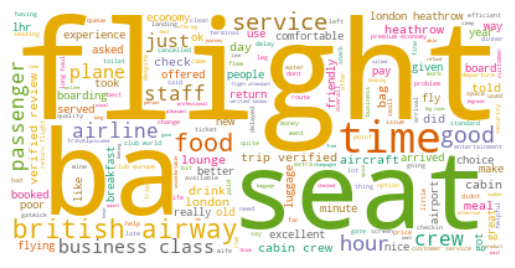

In [26]:
# wordcloud

!mkdir pics

wc = WordCloud(stopwords=text.ENGLISH_STOP_WORDS, 
               background_color="white", 
               colormap="Dark2",
               max_font_size=150, 
               random_state=42)

wc.generate(' '.join(list(review.values)))

plt.imshow(wc, interpolation="bilinear") 
plt.axis("off")
plt.savefig('.\\pics\\wordcloud.jpg')
plt.show()

---  
---  

### Sentiment Analysis

In [2]:
review = pickle.load(open('.\\pickle_review\\review.pkl', 'rb'))
review.head()

0    trip verified   booked a ba holiday to marrake...
1    trip verified  extremely subpar service highli...
2    trip verified   i virtually gave up on british...
3    trip verified   i was pleasantly surprised tha...
4    trip verified   british airways is late their ...
Name: review_clean, dtype: object

In [9]:
review = review.reset_index().drop('index', axis=1)

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

review['polarity'] = review['review_clean'].apply(pol)
review['subjectivity'] = review['review_clean'].apply(sub)
review.head()

,review_clean,polarity,subjectivity
0,trip verified booked a ba holiday to marrake...,0.157273,0.357576
1,trip verified extremely subpar service highli...,-0.025324,0.458519
2,trip verified i virtually gave up on british...,0.370972,0.569861
3,trip verified i was pleasantly surprised tha...,0.159470,0.619697
4,trip verified british airways is late their ...,-0.157143,0.410714


In [13]:
# Polarity: How positive or negative a word is. -1 is very negative. +1 is very positive.
# Subjectivity: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.

review[['polarity','subjectivity']].describe()

,polarity,subjectivity
count,3426.000000,3426.000000
mean,0.096512,0.491335
std,0.177366,0.108249
min,-0.766667,0.000000
25%,-0.013972,0.426081
50%,0.085124,0.490341
75%,0.204261,0.554821
max,0.800000,1.000000


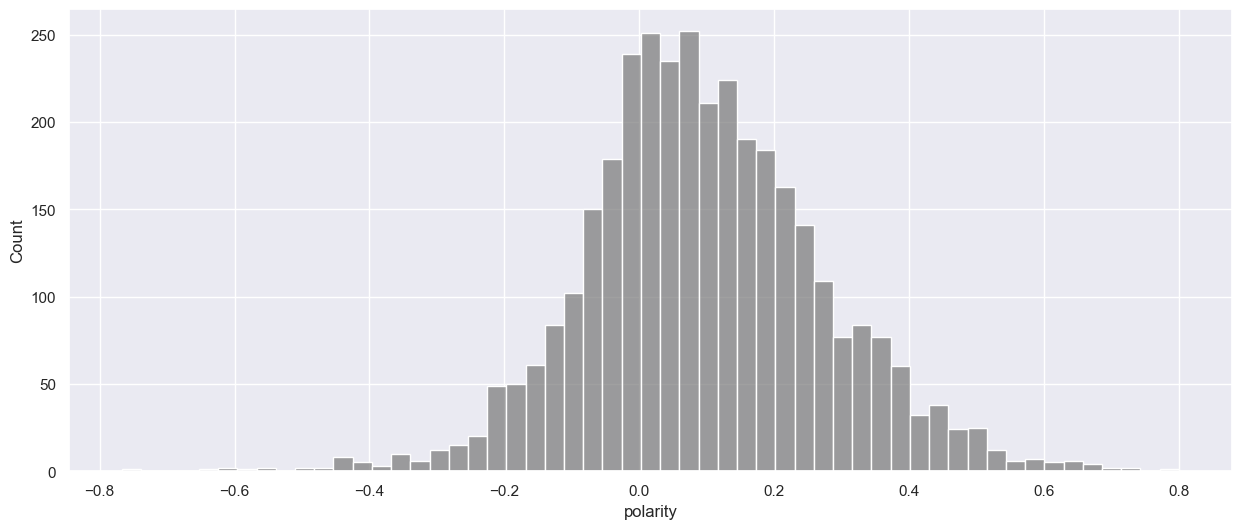

In [11]:
plt.figure(figsize=(15,6))

sns.histplot(review['polarity'], color='gray')
plt.show()

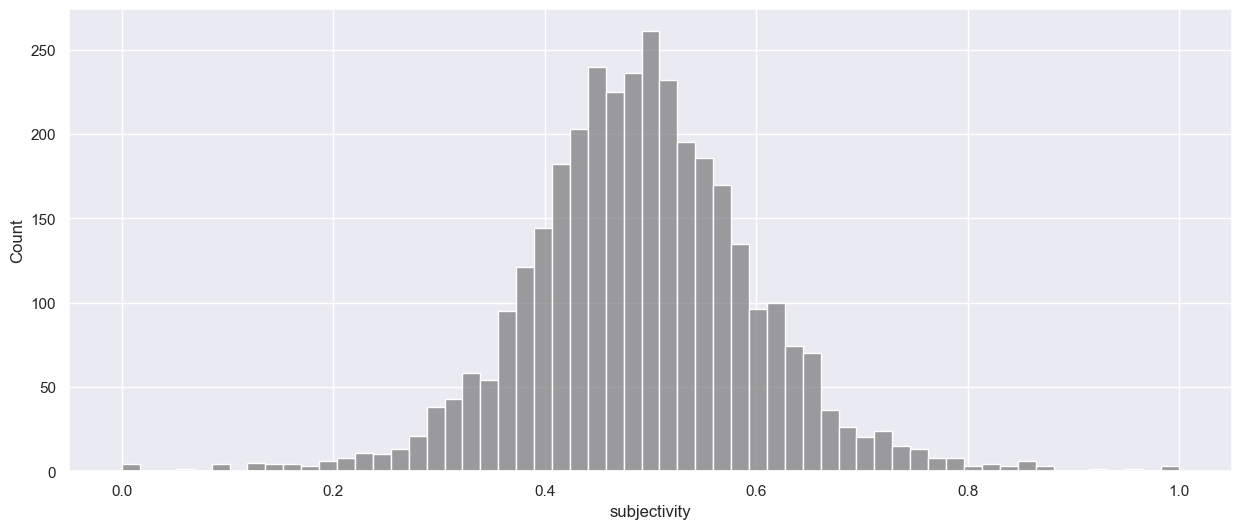

In [12]:
plt.figure(figsize=(15,6))

sns.histplot(review['subjectivity'], color='gray')
plt.show()

---  
---  

### Topic Modeling

In [3]:
# from df --> sparse matrix --> gensim corpus

sparse_counts = scipy.sparse.csr_matrix(dtm.T) # out: type -> scipy.sparse._csr.csr_matrix
corpus = matutils.Sparse2Corpus(sparse_counts) # out: type -> gensim.matutils.Sparse2Corpus

In [9]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix

id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [ ]:
# cv.vocabulary_.items() ### out: ('trip', 12180), ('verified', 12729)...

In [ ]:
# id2word ### out: {12180: 'trip', 12729: 'verified', 1298: 'booked', ...

In [11]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes

lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.016*"flight" + 0.014*"seat" + 0.014*"food" + 0.013*"class" + 0.012*"ba" + 0.012*"cabin" + 0.012*"economy" + 0.011*"service" + 0.011*"crew" + 0.010*"seats"'),
 (1,
  '0.032*"flight" + 0.013*"good" + 0.013*"crew" + 0.013*"time" + 0.011*"ba" + 0.011*"service" + 0.009*"boarding" + 0.008*"cabin" + 0.008*"food" + 0.008*"heathrow"'),
 (2,
  '0.023*"ba" + 0.023*"flight" + 0.011*"british" + 0.011*"airways" + 0.009*"seats" + 0.009*"london" + 0.008*"verified" + 0.008*"seat" + 0.007*"service" + 0.006*"airline"'),
 (3,
  '0.014*"ba" + 0.013*"seat" + 0.012*"seats" + 0.010*"food" + 0.010*"service" + 0.010*"club" + 0.009*"good" + 0.008*"cabin" + 0.007*"class" + 0.007*"new"')]

In [12]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.022*"flight" + 0.013*"good" + 0.012*"crew" + 0.012*"food" + 0.012*"ba" + 0.011*"seat" + 0.011*"cabin" + 0.011*"service" + 0.010*"seats" + 0.008*"time"'),
 (1,
  '0.033*"flight" + 0.017*"ba" + 0.009*"british" + 0.009*"airways" + 0.008*"london" + 0.008*"told" + 0.008*"hours" + 0.007*"time" + 0.007*"verified" + 0.006*"staff"'),
 (2,
  '0.024*"ba" + 0.012*"airways" + 0.012*"british" + 0.012*"service" + 0.009*"class" + 0.009*"london" + 0.009*"airline" + 0.009*"verified" + 0.009*"food" + 0.009*"business"')]

In [13]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.016*"flight" + 0.014*"ba" + 0.014*"seat" + 0.012*"food" + 0.012*"seats" + 0.011*"class" + 0.010*"service" + 0.010*"cabin" + 0.009*"business" + 0.009*"economy"'),
 (1,
  '0.029*"flight" + 0.017*"ba" + 0.010*"time" + 0.009*"service" + 0.008*"london" + 0.008*"good" + 0.007*"crew" + 0.007*"british" + 0.007*"airways" + 0.007*"staff"')]

In [14]:
# Topic 1: overall flight experience
# Topic 2: facilities (seat, food, class)